In [13]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
import seaborn as sns
from utils import argmax
from tqdm import tqdm
from scipy.interpolate import make_interp_spline

In [14]:
# 1. Load Environment and Q-table structure
env = gym.make('CliffWalking-v0')

In [15]:
# checking observations space, action space and reward
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Discrete(48)
Discrete(4)
(-inf, inf)


In [4]:
# Set parameters
num_actions = env.action_space.n
num_states = env.observation_space.n
learning_rate = .5
epsilon = 0.1
gamma = 1.0
episodes = 500
runs = 10
all_state_visits = {}

# Q-learning

In [5]:
# 2. Parameters of Q-learning
algorithm = "Q-Learning"
all_rewards_Q_learning = []
Q_ql = np.zeros([num_states, num_actions])
all_state_visits[algorithm] = []

# 3. Q-learning Algorithm
for run in tqdm(range(runs)):
    rewards_per_run = [] # rewards per episode calculate
    rand_generator = np.random.RandomState(seed=run)
    state_visits = np.zeros(num_states)
    
    for i in range(episodes):

        # reset environment
        state = env.reset()[0]
        cumulative_reward = 0
        terminated = False
        j = 0
        current_q = Q_ql[state,:]

        #The Q-Table learning algorithm
        while j < 1000:
            env.render()
            j+=1
            # Choose action from Q table with epsilon-soft policy
            if rand_generator.rand() < epsilon:
                action = rand_generator.randint(num_actions)
            else:
                # action = np.argmax(Q[state,:])
                action = np.random.choice(np.flatnonzero(Q_ql[state,:] == Q_ql[state,:].max()))

            # get new state and reward from environment
            state_new, reward, terminated, truncated, info = env.step(action)

            # update Q with new knowledge
            if terminated:
                delta = reward - Q_ql[state, action]
            else:
                delta = reward + gamma * np.max(Q_ql[state_new,:]) - Q_ql[state, action]
                
            Q_ql[state, action] += learning_rate * delta
            cumulative_reward += reward
            state = state_new
            if i >= episodes - 10:
                state_visits[state] += 1

            if terminated or truncated:
                break
            
        # append cumulative reward of this episode to list
        rewards_per_run.append(cumulative_reward)
        env.render()
    
    # append 
    all_rewards_Q_learning.append(rewards_per_run)
    all_state_visits[algorithm].append(state_visits)
    env.close()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/makotomiyazaki/.pyenv/versions/3.11.5/envs/rl/lib/python3.11/site-packages/gymnasium/envs/toy_text/cliffwalking.py:196: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CliffWalking-v0", render_mode="rgb_array")
  gym.logger.warn(
100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


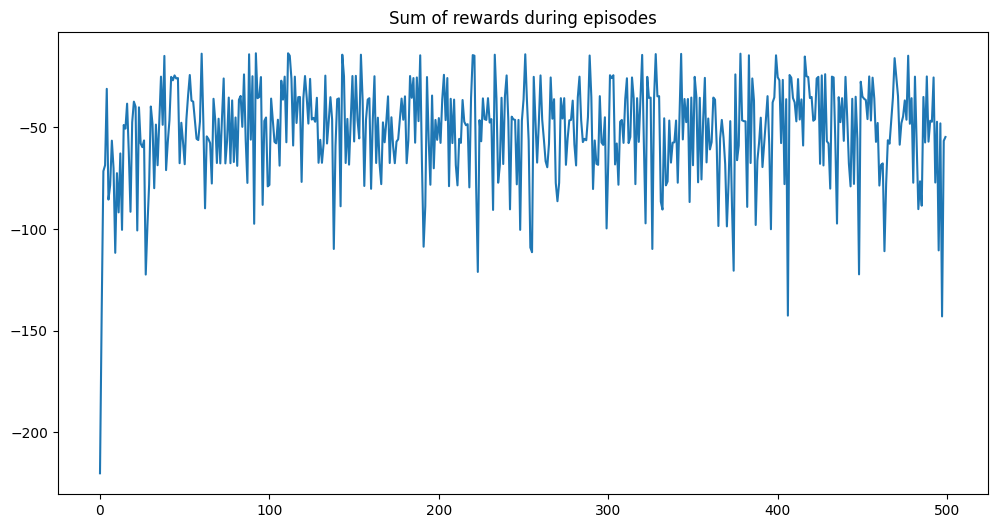

In [6]:
plt.figure(figsize=(12,6))
x = range(episodes)
y = np.mean(all_rewards_Q_learning, axis=0)
plt.plot(x, y)
plt.title("Sum of rewards during episodes")
plt.show()

# Expected SARSA

In [7]:
# 2. Parameters of Expected SARSA
algorithm = "Expected SARSA"
all_rewards_exp_SARSA = []
Q_xSARSA = np.zeros([num_states, num_actions])
all_state_visits[algorithm] = []

# 3. Expected SARSA Algorithm
for run in tqdm(range(runs)):
    rewards_per_run = [] # rewards per episode calculate
    rand_generator = np.random.RandomState(seed=run)
    state_visits = np.zeros(num_states)
    
    for i in range(episodes):

        # reset environment
        state = env.reset()[0]
        cumulative_reward = 0
        terminated = False
        j = 0
        current_q = Q_xSARSA[state,:]

        #The Q-Table learning algorithm
        while j < 1000:
            env.render()
            j+=1
            # Choose action from Q table with epsilon-soft policy
            if rand_generator.rand() < epsilon:
                action = rand_generator.randint(num_actions)
            else:
                # action = np.argmax(Q[state,:])
                action = np.random.choice(np.flatnonzero(Q_xSARSA[state,:] == Q_xSARSA[state,:].max()))

            # get new state and reward from environment
            state_new, reward, terminated, truncated, info = env.step(action)

            # update Q with new knowledge
            prob_greedy = 1.0 - epsilon
            prob_non_greedy = epsilon/env.action_space.n

            if terminated:
                delta = reward - Q_xSARSA[state, action]
            else:
                delta = reward + gamma * (prob_greedy * np.max(Q_xSARSA[state_new,:]) + prob_non_greedy * np.sum(Q_xSARSA[state_new,:])) - Q_xSARSA[state, action]
            Q_xSARSA[state, action] += learning_rate * delta
            cumulative_reward += reward
            state = state_new
            if i >= episodes - 10:
                state_visits[state] += 1

            if terminated or truncated:
                break
            
        # append cumulative reward of this episode to list
        rewards_per_run.append(cumulative_reward)
        all_state_visits[algorithm].append(state_visits)
        env.render()
    
    # append 
    all_rewards_exp_SARSA.append(rewards_per_run)
    env.close()

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


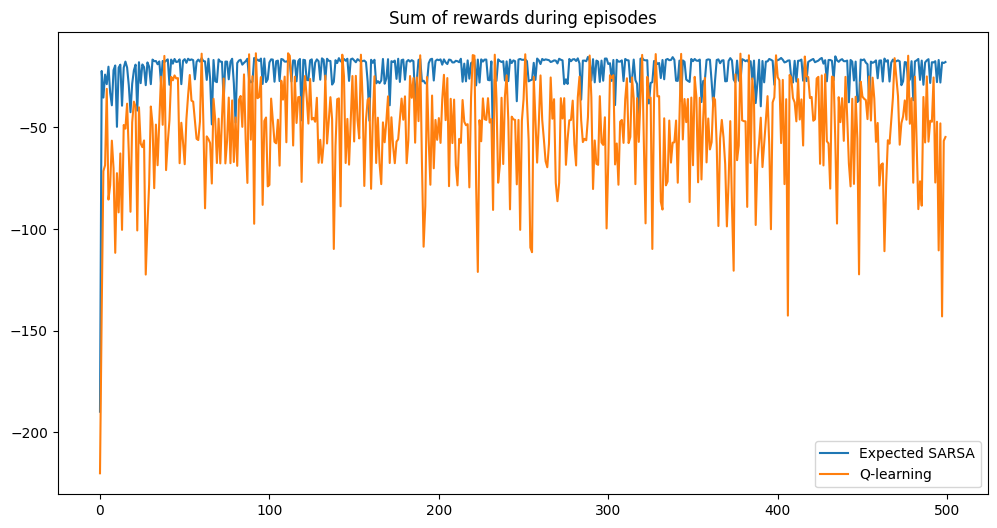

In [8]:
plt.figure(figsize=(12,6))
x = range(episodes)
y_xSARSA = np.mean(all_rewards_exp_SARSA, axis=0)
y_ql = np.mean(all_rewards_Q_learning, axis=0)
plt.plot(x, y_xSARSA, label="Expected SARSA")
plt.plot(x, y_ql, label="Q-learning")
plt.title("Sum of rewards during episodes")
plt.legend()
plt.show()

# Visualizing visited states

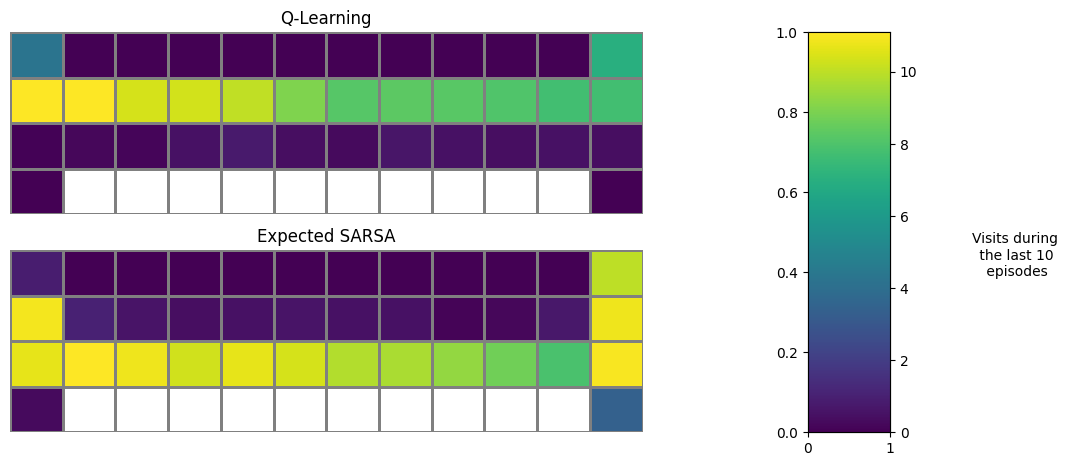

In [9]:
plt.figure(figsize=(11,4))
for algo, position in [("Q-Learning", 211), ("Expected SARSA", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algo]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algo)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

# Visualizing actions

In [10]:
Q_max_actions = [np.argmax(Q_xSARSA[i,:]) for i in range(len(Q_xSARSA))]
Q_decoded = np.empty_like(Q_max_actions, dtype="str")
for i in range(len(Q_max_actions)):
    if Q_max_actions[i] == 0:
        Q_decoded[i] = "↑"
    elif Q_max_actions[i] == 1:
        Q_decoded[i] = "→"
    elif Q_max_actions[i] == 2:
        Q_decoded[i] = "↓"
    else:
        Q_decoded[i] = "←"
print("Expected SARSA in action")
print(np.reshape(Q_decoded, (4,12)))

Expected SARSA in action
[['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑']]


In [11]:
Q_max_actions = [np.argmax(Q_ql[i,:]) for i in range(len(Q_ql))]
Q_decoded = np.empty_like(Q_max_actions, dtype="str")
for i in range(len(Q_max_actions)):
    if Q_max_actions[i] == 0:
        Q_decoded[i] = "↑"
    elif Q_max_actions[i] == 1:
        Q_decoded[i] = "→"
    elif Q_max_actions[i] == 2:
        Q_decoded[i] = "↓"
    else:
        Q_decoded[i] = "←"
print("Q-Learning in action")
print(np.reshape(Q_decoded, (4,12)))

Q-Learning in action
[['←' '↓' '→' '↓' '→' '→' '→' '→' '↓' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑']]
